In [ ]:

import pandas as pd
import numpy as np
from scipy.stats import linregress
from sklearn.preprocessing import MinMaxScaler

# df 경로는 각자 설정
df = pd.read_csv("../데이터/vip_customers_all.csv")
# df = df.sort_values(by=['발급회원번호', '기준년월'])

# -------------------------------------------------------
# 1. 6개월 기울기(Slope) 계산 (df에 바로 생성)
# -------------------------------------------------------
def calc_slope_6m(series):
    if len(series) < 2 or np.sum(series) == 0: return 0
    y = series.values
    x = np.arange(len(y))
    slope, _, _, _, _ = linregress(x, y)
    return slope

# transform으로 전체 데이터에 기울기 적용
df['Slope_Spend'] = df.groupby('발급회원번호')['이용금액_신용_B0M'].transform(calc_slope_6m)
df['Slope_Balance'] = df.groupby('발급회원번호')['잔액_B0M'].transform(calc_slope_6m)
df['Slope_Count'] = df.groupby('발급회원번호')['이용건수_신용_B0M'].transform(calc_slope_6m)

# -------------------------------------------------------
# 2. 현재 시점(12월) 데이터만 추출
# -------------------------------------------------------
target_month = df['기준년월'].max()
df_final = df[df['기준년월'] == target_month].copy()

# -------------------------------------------------------
# 3. [핵심] 기울기를 '이탈 점수'로 변환 (Normalization)
# -------------------------------------------------------
# 전략: 기울기가 음수일수록(가파른 감소) 높은 점수를 줍니다.
# 양수(증가)인 경우는 이탈 위험이 없으므로 0점으로 처리합니다.

scaler = MinMaxScaler()

def convert_slope_to_score(col_name):
    # 1. 감소하는 경우(음수)만 추출, 나머지는 0으로 대치
    # (음수 값에 -1을 곱해 양수로 만듦: -5000 -> 5000)
    # 즉, 값이 클수록 '많이 줄어듦'을 의미하게 됨
    negative_slopes = df_final[col_name].apply(lambda x: -x if x < 0 else 0)
    
    # 2. 0~1 사이 값으로 정규화 (MinMax Scaling)
    # 가장 많이 줄어든 사람이 1.0, 안 줄어든 사람이 0.0
    return scaler.fit_transform(negative_slopes.values.reshape(-1, 1)).flatten()

# 각 지표별 '감소 심각도' (0.0 ~ 1.0)
score_spend_norm = convert_slope_to_score('Slope_Spend')
score_balance_norm = convert_slope_to_score('Slope_Balance')
score_count_norm = convert_slope_to_score('Slope_Count')

# -------------------------------------------------------
# 4. 가중치 적용 및 최종 점수 산출 (100점 만점)
# -------------------------------------------------------
# 가중치 설정 (비즈니스 중요도에 따라 조절 가능)
W_SPEND = 40   # 소비 감소 비중
W_BALANCE = 30 # 잔액 감소(이탈준비) 비중
W_COUNT = 20   # 빈도 감소 비중
W_RISK = 10    # 현재 연체 등 리스크 비중

# (1) 리스크 점수 별도 계산 (0 or 10점)
# 연체나 승인거절이 하나라도 있으면 10점 만점 부여
has_risk = np.where(
    (df_final.get('연체잔액_B0M', 0) > 0) | 
    (df_final.get('승인거절건수_B0M', 0) > 0), 
    1, 0
)

# (2) 최종 스코어 계산
df_final['Churn_Score'] = (
    (score_spend_norm * W_SPEND) + 
    (score_balance_norm * W_BALANCE) + 
    (score_count_norm * W_COUNT) + 
    (has_risk * W_RISK)
)

# 소수점 정리
df_final['Churn_Score'] = df_final['Churn_Score'].round(1)

# 출력
print("\n[이탈 위험 점수(Churn Score) 상위 10명]")
cols_view = ['발급회원번호', 'Slope_Spend', 'Slope_Balance', 'Churn_Score']
print(df_final[cols_view].sort_values('Churn_Score', ascending=False).head(10))

/var/folders/3p/8hc9c44s38j902ytq253kt6m0000gn/T/ipykernel_4988/676469181.py:7: DtypeWarning: Columns (339) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv("../데이터/vip_customers_all.csv")



[이탈 위험 점수(Churn Score) 상위 10명]
         발급회원번호    Slope_Spend  Slope_Balance  Churn_Score
10182  SYN_3968 -243906.428571 -117226.657143         63.7
10493  SYN_5296 -206826.314286 -381888.542857         55.4
11244  SYN_9037 -229686.857143 -119831.371429         54.9
10079  SYN_3442 -168908.285714 -186469.485714         51.4
9667   SYN_1527 -186951.657143 -241112.200000         49.6
10057   SYN_334 -153861.142857 -243873.228571         49.0
9803   SYN_2164 -150169.828571 -159142.771429         48.1
10522  SYN_5434 -161439.171429 -192306.314286         43.3
10539  SYN_5537 -172069.714286 -152554.742857         42.9
10603  SYN_5905 -170207.685714 -156450.228571         41.7



[클러스터별 평균 특성 확인]
            Churn_Score   Slope_Spend
Cluster_ID                           
0             27.715556 -84954.710349
1             11.438158 -24657.012782
2              2.380108  17327.987892


/usr/local/Caskroom/miniconda/base/envs/myenv/lib/python3.13/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 51060 (\N{HANGUL SYLLABLE I}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/Caskroom/miniconda/base/envs/myenv/lib/python3.13/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 53448 (\N{HANGUL SYLLABLE TAL}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/Caskroom/miniconda/base/envs/myenv/lib/python3.13/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 51216 (\N{HANGUL SYLLABLE JEOM}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/Caskroom/miniconda/base/envs/myenv/lib/python3.13/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 49688 (\N{HANGUL SYLLABLE SU}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/Caskroom/miniconda/base/envs/myenv/lib/python3.13/site-

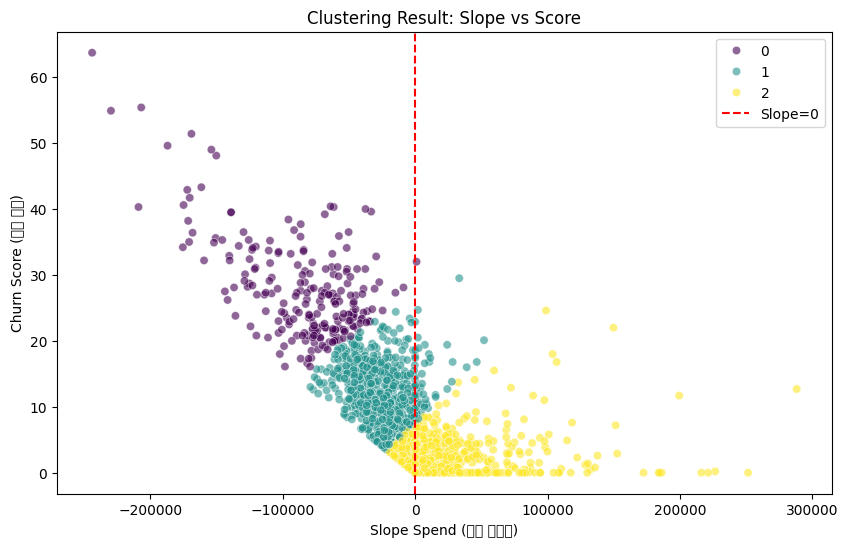

------------------------------
[클러스터별 분포 현황]
            인원수(명)  비율(%)
Cluster_ID               
0              225  11.78
1              760  39.79
2              925  48.43
------------------------------
▶ [Cluster 0] 위험군 비율: 11.78%
▶ [Cluster 0] 인원수: 225명


In [5]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler

# 각자 컴퓨터에서 df 로드하고 
# df_final 에 Churn_Score 만드는 코드까지 작성한 후에 아래 코드 실행! 


# 1. 클러스터링에 사용할 핵심 변수 선택
# (Churn_Score와 Slope_Spend 두 가지로 군집화)
cluster_cols = ['Churn_Score', 'Slope_Spend']

# 데이터 준비
X_cluster = df_final[cluster_cols].copy()

# 2. 스케일링 (필수)
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_cluster)

# 3. K-Means 클러스터링 (K=3)
kmeans = KMeans(n_clusters=3, random_state=42)
clusters = kmeans.fit_predict(X_scaled)

# 원본 데이터에 클러스터 라벨 붙이기
df_final['Cluster_ID'] = clusters

# -------------------------------------------------------
# 4. 결과 해석 (통계)
# -------------------------------------------------------
print("\n[클러스터별 평균 특성 확인]")
print(df_final.groupby('Cluster_ID')[cluster_cols].mean())

# -------------------------------------------------------
# 5. 시각화 (수정됨: 클러스터링 변수와 축 일치시키기)
# -------------------------------------------------------
plt.figure(figsize=(10, 6))

# X축: 소비 기울기 (Slope_Spend)
# Y축: 이탈 점수 (Churn_Score)
sns.scatterplot(
    data=df_final, 
    x='Slope_Spend', 
    y='Churn_Score', 
    hue='Cluster_ID', 
    palette='viridis',
    alpha=0.6
)

plt.title('Clustering Result: Slope vs Score')
plt.xlabel('Slope Spend (소비 기울기)')
plt.ylabel('Churn Score (이탈 점수)')

# 기준선 추가 (보기 편하게)
plt.axvline(x=0, color='r', linestyle='--', label='Slope=0') 
plt.legend()
plt.show()

# -------------------------------------------------------
# 6. 클러스터 0 (또는 특정 그룹) 비중 확인 코드
# -------------------------------------------------------
# 전체 인원수 및 비율 계산
cluster_counts = df_final['Cluster_ID'].value_counts().sort_index()
cluster_ratios = df_final['Cluster_ID'].value_counts(normalize=True).sort_index() * 100

print("-" * 30)
print("[클러스터별 분포 현황]")
df_summary = pd.DataFrame({
    '인원수(명)': cluster_counts,
    '비율(%)': cluster_ratios.round(2)
})
print(df_summary)
print("-" * 30)

# 만약 0번 그룹을 위험군으로 본다면:
target_group = 0 
print(f"▶ [Cluster {target_group}] 위험군 비율: {cluster_ratios[target_group]:.2f}%")
print(f"▶ [Cluster {target_group}] 인원수: {cluster_counts[target_group]:,}명")
     

In [6]:
# -------------------------------------------------------
# 7. Target 변수 생성 (이탈 여부 정의)
# -------------------------------------------------------
# 요청사항: Cluster 0 -> 1 (이탈/위험군)
#          Cluster 1, 2 -> 0 (일반/유지)

df_final['Target'] = df_final['Cluster_ID'].apply(lambda x: 1 if x == 0 else 0)

# 잘 만들어졌는지 분포 확인
target_counts = df_final['Target'].value_counts().sort_index()
target_ratio = df_final['Target'].value_counts(normalize=True).sort_index() * 100

print("\n" + "="*40)
print("[최종 Target 변수 생성 결과]")
print(f"▶ 이탈(1) : {target_counts.get(1, 0)}명 ({target_ratio.get(1, 0):.2f}%) - (기존 Cluster 0)")
print(f"▶ 유지(0) : {target_counts.get(0, 0)}명 ({target_ratio.get(0, 0):.2f}%) - (기존 Cluster 1, 2)")
print("="*40)

# -------------------------------------------------------
# 8. 최종 결과 CSV 파일 저장
# -------------------------------------------------------
file_name = "VIP_With_Target.csv"
df_final.to_csv(file_name, index=False, encoding='utf-8-sig')

print(f"\n🎉 저장 완료! '{file_name}' 파일이 생성되었습니다.")


[최종 Target 변수 생성 결과]
▶ 이탈(1) : 225명 (11.78%) - (기존 Cluster 0)
▶ 유지(0) : 1685명 (88.22%) - (기존 Cluster 1, 2)

🎉 저장 완료! 'VIP_With_Target.csv' 파일이 생성되었습니다.
